# BPS5231 AI For Sustainable Building Design - L5

🌳 In-Class Activity: Random Forests (Regression & Classification)

**Today’s goals**
- Build intuition for **bagging** and **Random Forests**.
- Train & evaluate **RandomForestRegressor** and **RandomForestClassifier** in scikit-learn.
- Read **feature importances**, try **permutation importance** and **partial dependence**.
- Do a tiny **hyperparameter sweep** + discuss over/underfitting.

**What we’ll use**
- California Housing dataset (regression)
- A synthetic dataset (classification)

In [ ]:
# If needed on a fresh runtime:
# !pip install -q scikit-learn matplotlib numpy pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, confusion_matrix,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.datasets import fetch_california_housing, make_classification

np.random.seed(42)
plt.rcParams["figure.figsize"] = (8, 5)


## What is a Random Forest? (1-minute intuition)

- **Bagging**: train many trees on **bootstrapped** (resampled) data.
- **Random subspace**: at each split, consider only a **random subset of features** → trees become **less correlated**.
- **Aggregate**:
  - Regression → **average** tree predictions
  - Classification → **majority vote**
- Pros: handles nonlinearity/interaction, minimal preprocessing, strong default baseline.
- Cons: larger models, can still overfit if trees are too deep; fewer global explanations than linear models.


## Part A — Regression with California Housing
We’ll predict median house value as a stand-in for continuous built-environment targets (e.g., energy use/comfort indices).


In [ ]:
cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

X_train.shape, X_valid.shape, X_test.shape

((14448, 8), (3096, 8), (3096, 8))

### Baseline RandomForestRegressor
Settings to start:
- `n_estimators=300` (more trees → more stable)
- `max_features='sqrt'` (classic RF)
- `oob_score=True` to get an out-of-bag estimate (like built-in CV)

In [ ]:
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,            # let trees grow; we may cap later
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)

print("OOB R^2:", getattr(rf_reg, "oob_score_", None))
print("Train R^2:", rf_reg.score(X_train, y_train))
print("Valid R^2:", rf_reg.score(X_valid, y_valid))

OOB R^2: 0.8152883092076255
Train R^2: 0.974786902427378
Valid R^2: 0.8024877088986702


Test RMSE: 0.2289
Test R^2 : 0.8269


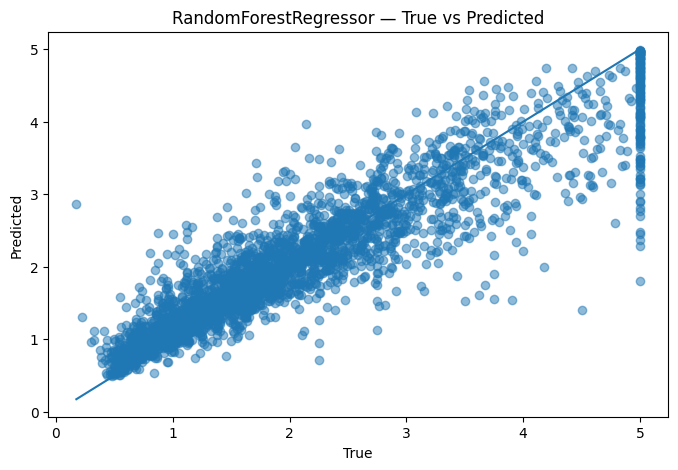

In [ ]:
y_pred = rf_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R^2 : {r2:.4f}")

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.5)
m = min(y_test.min(), y_pred.min())
M = max(y_test.max(), y_pred.max())
plt.plot([m, M], [m, M])
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("RandomForestRegressor — True vs Predicted")
plt.show()

### Feature importances
- **Impurity-based** (built-in): fast, but can be biased toward high-cardinality features.
- **Permutation importance** (on validation): slower but more faithful to predictive impact.

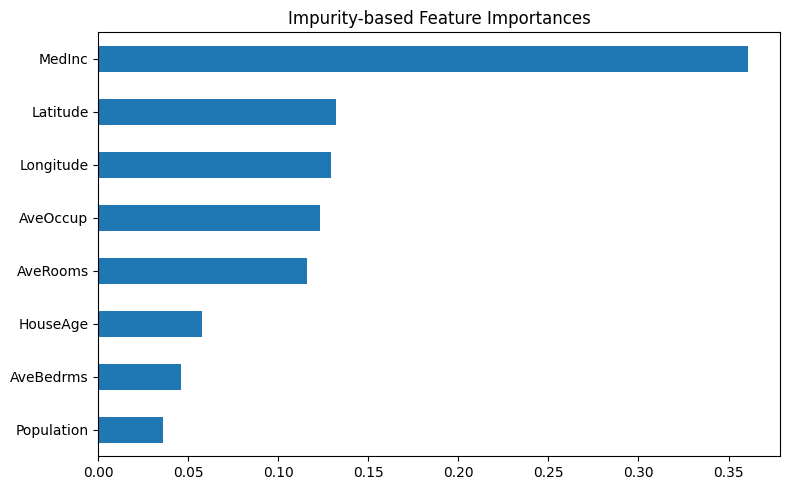

,0
MedInc,0.360564
Latitude,0.131905
Longitude,0.129477
AveOccup,0.123205
AveRooms,0.115857
HouseAge,0.057442
AveBedrms,0.045646
Population,0.035904


In [ ]:
impurity_imp = pd.Series(rf_reg.feature_importances_, index=X.columns).sort_values()
impurity_imp.plot(kind="barh")
plt.title("Impurity-based Feature Importances")
plt.tight_layout()
plt.show()

impurity_imp.sort_values(ascending=False).head(10)

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


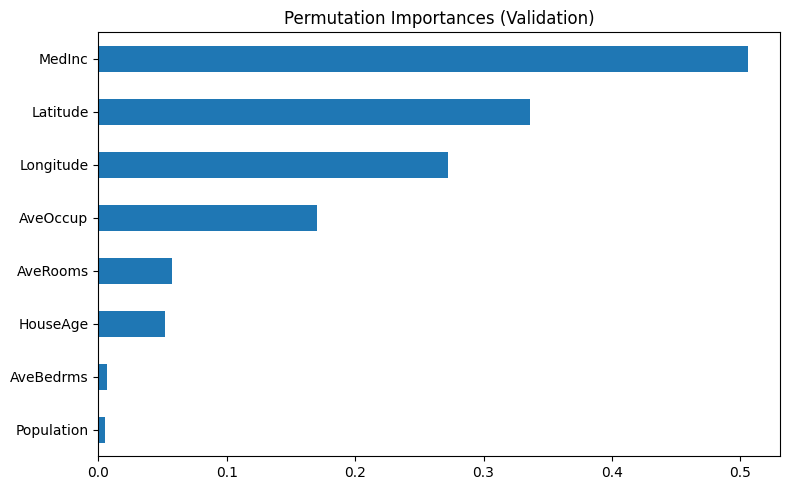

,0
MedInc,0.505634
Latitude,0.336300
Longitude,0.272596
AveOccup,0.170364
AveRooms,0.057180
HouseAge,0.052094
AveBedrms,0.006916
Population,0.005203


In [ ]:
perm = permutation_importance(
    rf_reg, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1
)
perm_imp = pd.Series(perm.importances_mean, index=X.columns).sort_values()
perm_imp.plot(kind="barh")
plt.title("Permutation Importances (Validation)")
plt.tight_layout()
plt.show()

perm_imp.sort_values(ascending=False).head(10)

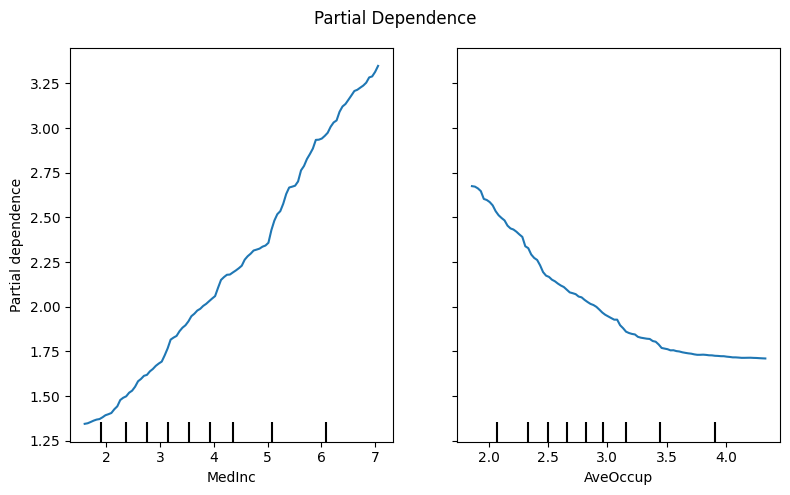

In [ ]:
# Pick a couple of strong features (adjust if needed)
features_to_plot = ["MedInc", "AveOccup"]  # income, occupancy
PartialDependenceDisplay.from_estimator(rf_reg, X_valid, features=features_to_plot)
plt.suptitle("Partial Dependence")
plt.tight_layout()
plt.show()

### Mini hyperparameter sweep (depth × trees)
We’ll see how depth and number of trees affect **Train** vs **Valid** R² (bias/variance).

In [ ]:
depths = [1, 5, 10]
trees  = [50, 100, 200, 300]

records = []
for d in depths:
    for n in trees:
        m = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            max_features="sqrt",
            random_state=42,
            n_jobs=-1
        )
        m.fit(X_train, y_train)
        records.append({
            "max_depth": d,
            "n_estimators": n,
            "Train_R2": m.score(X_train, y_train),
            "Valid_R2": m.score(X_valid, y_valid)
        })

res_df = pd.DataFrame(records).sort_values(["max_depth","n_estimators"])
res_df

,max_depth,n_estimators,Train_R2,Valid_R2
0,1,50,0.234172,0.217769
1,1,100,0.212972,0.198861
2,1,200,0.220975,0.207525
3,1,300,0.220118,0.206408
4,5,50,0.645499,0.608199
5,5,100,0.643167,0.605854
6,5,200,0.646628,0.609083
7,5,300,0.645548,0.609403
8,10,50,0.842075,0.753410
9,10,100,0.843658,0.754944


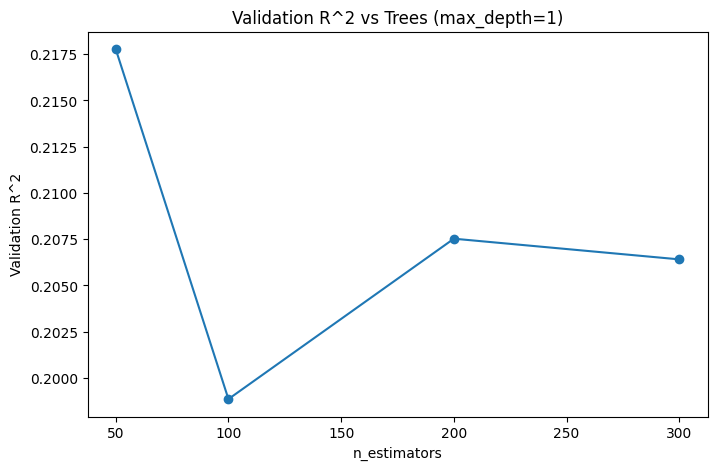

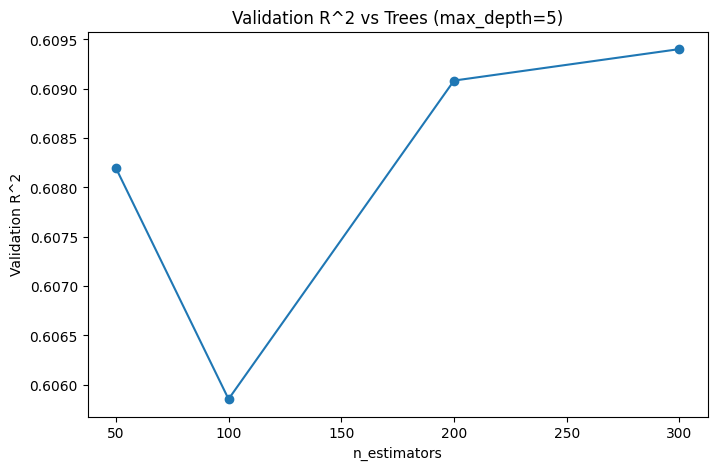

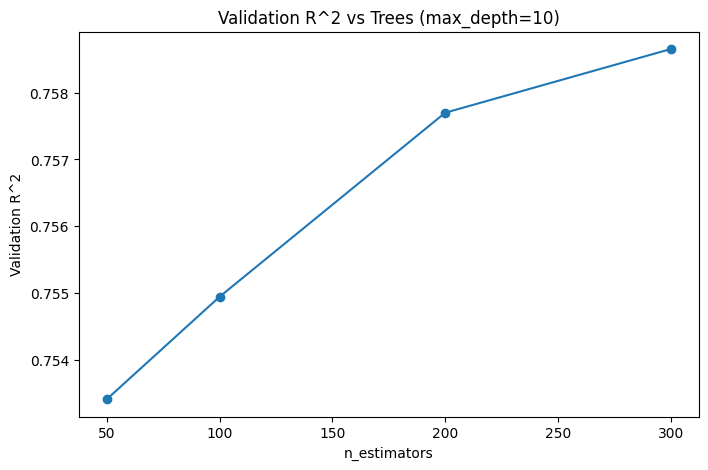

In [ ]:
# Plot Valid R^2 vs n_estimators for each depth
for d in res_df["max_depth"].unique():
    sub = res_df[res_df["max_depth"]==d].sort_values("n_estimators")
    plt.figure()
    plt.plot(sub["n_estimators"], sub["Valid_R2"], marker="o")
    plt.xlabel("n_estimators")
    plt.ylabel("Validation R^2")
    plt.title(f"Validation R^2 vs Trees (max_depth={d})")
    plt.show()

## Part B — Classification with **XGBoost** + Interpretability Tools
We’ll switch from Random Forests to **XGBoost** (gradient boosted trees) for classification, then visualize:
- Performance (Accuracy, ROC-AUC, Confusion Matrix)
- **A learned tree** with **GraphViz**
- An **Explainer Dashboard** (SHAP-based) for global & local explanations

In [ ]:
# If running on a fresh environment, uncomment:
!pip install -q xgboost graphviz explainerdashboard shap

# If you're on Colab or a machine without Graphviz binaries, you may need:
!apt-get -y install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

# GraphViz renderer
from graphviz import Source

# SHAP-based dashboard
from explainerdashboard import ClassifierExplainer, ExplainerDashboard

np.random.seed(42)
plt.rcParams["figure.figsize"] = (8, 5)

### Load Titanic
We try seaborn’s `titanic` (simple schema). If not available or offline, we fall back to OpenML’s `titanic`.
We’ll keep a **clean feature set**: `['pclass','sex','age','sibsp','parch','fare','embarked']`
and drop leakage/duplicates like `alive`, `class`, `embark_town`, `adult_male`, `deck`.

In [ ]:
# Try seaborn first
titanic = None
try:
    import seaborn as sns
    titanic = sns.load_dataset("titanic")
except Exception as e:
    print("Seaborn load_dataset('titanic') failed, trying OpenML...", e)

if titanic is None:
    from sklearn.datasets import fetch_openml
    df_oml = fetch_openml(name="titanic", version=1, as_frame=True).frame
    # Try to align to seaborn-like columns
    # Common columns in OpenML version: 'pclass','sex','age','sibsp','parch','fare','embarked','survived'
    # Values in 'survived' may be '0'/'1' strings or 'yes'/'no'.
    def to_int01(s):
        try:
            return s.astype(int)
        except Exception:
            return s.map({"yes":1, "no":0, "Yes":1, "No":0, "alive":1, "dead":0}).astype(int)

    candidates = ["survived","Survived","survival","class"]
    target_col = next((c for c in candidates if c in df_oml.columns), None)
    if target_col is None:
        raise ValueError(f"Could not find target column among {candidates}. Columns present: {list(df_oml.columns)}")
    df_oml = df_oml.copy()
    y_oml = to_int01(df_oml[target_col]).astype(int)

    keep = [c for c in ["pclass","sex","age","sibsp","parch","fare","embarked"] if c in df_oml.columns]
    X_oml = df_oml[keep].copy()
    X_oml["pclass"] = pd.to_numeric(X_oml["pclass"], errors="coerce")
    titanic = pd.concat([X_oml, y_oml.rename("survived")], axis=1)

# Standardize column names (lowercase)
titanic.columns = [c.lower() for c in titanic.columns]

# Drop known leakage/duplicates if present
drop_cols = [c for c in ["alive","class","embark_town","adult_male","who","deck","alone"] if c in titanic.columns]
titanic = titanic.drop(columns=drop_cols, errors="ignore")

# Keep a clean feature set
features = [c for c in ["pclass","sex","age","sibsp","parch","fare","embarked"] if c in titanic.columns]
assert "survived" in titanic.columns, "Target 'survived' not found after loading."
X_raw = titanic[features].copy()
y = titanic["survived"].astype(int)

X_raw.head(), y.value_counts(normalize=True).round(3)

(   pclass     sex   age  sibsp  parch     fare embarked
 0       3    male  22.0      1      0   7.2500        S
 1       1  female  38.0      1      0  71.2833        C
 2       3  female  26.0      0      0   7.9250        S
 3       1  female  35.0      1      0  53.1000        S
 4       3    male  35.0      0      0   8.0500        S,
 survived
 0    0.616
 1    0.384
 Name: proportion, dtype: float64)

### Split

In [ ]:
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_raw, y, test_size=0.30, stratify=y, random_state=42
)
X_valid_raw, X_test_raw, y_valid, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

X_train_raw.shape, X_valid_raw.shape, X_test_raw.shape

((623, 7), (134, 7), (134, 7))

### Preprocessing (Impute + One-Hot)
- Numeric: median imputation  
- Categorical: most-frequent imputation + one-hot (ignore unknowns)
We’ll transform to a **DataFrame with informative column names** so XGBoost can keep feature names (nice for GraphViz + SHAP).

In [ ]:
from sklearn.pipeline import Pipeline

num_cols = [c for c in X_train_raw.columns if X_train_raw[c].dtype != "object"]
cat_cols = [c for c in X_train_raw.columns if X_train_raw[c].dtype == "object"]

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Fit on train; transform all splits
X_train_np = preprocess.fit_transform(X_train_raw)
X_valid_np = preprocess.transform(X_valid_raw)
X_test_np  = preprocess.transform(X_test_raw)

# Get feature names and wrap as DataFrame
feat_names = preprocess.get_feature_names_out()
X_train = pd.DataFrame(X_train_np, columns=feat_names, index=X_train_raw.index)
X_valid = pd.DataFrame(X_valid_np, columns=feat_names, index=X_valid_raw.index)
X_test  = pd.DataFrame(X_test_np,  columns=feat_names,  index=X_test_raw.index)

X_train.head()

,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
748,1.0,19.0,1.0,0.0,53.1000,0.0,1.0,0.0,0.0,1.0
45,3.0,29.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,1.0
28,3.0,29.0,0.0,0.0,7.8792,1.0,0.0,0.0,1.0,0.0
633,1.0,29.0,0.0,0.0,0.0000,0.0,1.0,0.0,0.0,1.0
403,3.0,28.0,1.0,0.0,15.8500,0.0,1.0,0.0,0.0,1.0


### Train **XGBoost** (no early stopping, 100 estimators)
We keep parameters modest for quick classroom runs.

In [ ]:
xgb_clf = XGBClassifier(
    n_estimators=100,          # per request
    learning_rate=0.1,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_clf.fit(X_train, y_train)
print("Train AUC:", roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:,1]).round(3))
print("Valid AUC:", roc_auc_score(y_valid, xgb_clf.predict_proba(X_valid)[:,1]).round(3))


Train AUC: 0.965
Valid AUC: 0.89


Test Accuracy: 0.776
Test ROC-AUC : 0.820


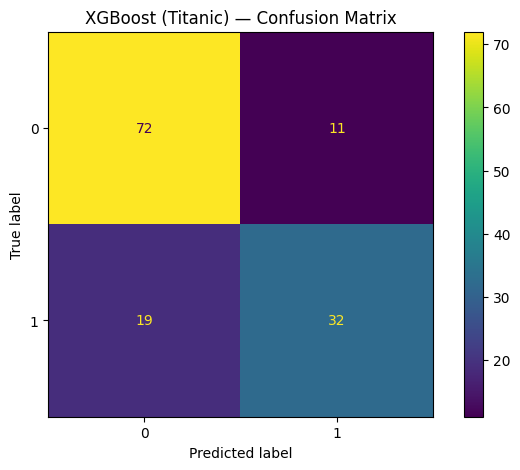

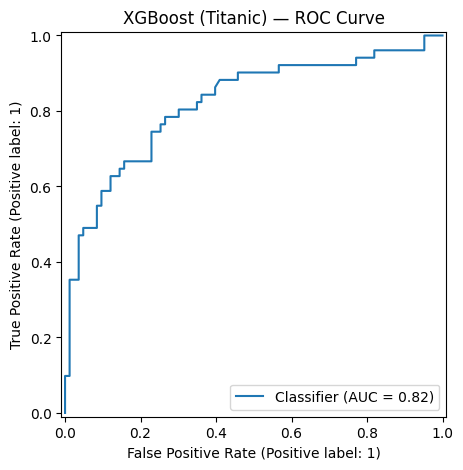

In [ ]:
y_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print(f"Test Accuracy: {acc:.3f}")
print(f"Test ROC-AUC : {auc:.3f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("XGBoost (Titanic) — Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("XGBoost (Titanic) — ROC Curve")
plt.show()

### Feature Importance (Gain)
Model-specific importance from XGBoost. For model-agnostic perspectives, we’ll use the SHAP-based dashboard below.

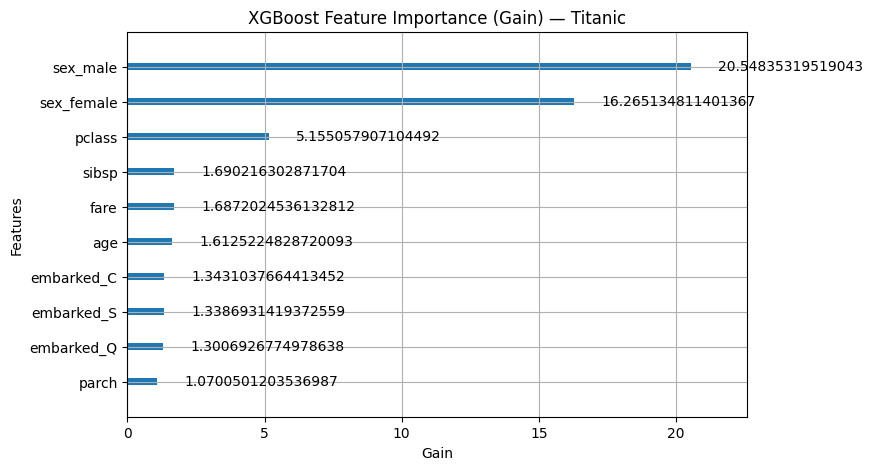

In [ ]:
plot_importance(xgb_clf, importance_type="gain", xlabel="Gain")
plt.title("XGBoost Feature Importance (Gain) — Titanic")
plt.show()

### Visualize a Learned Tree with GraphViz
We export one of the trees in **DOT** format and render it.
> If Graphviz binaries are missing, either install them, or save the DOT to file and view via an online DOT viewer.

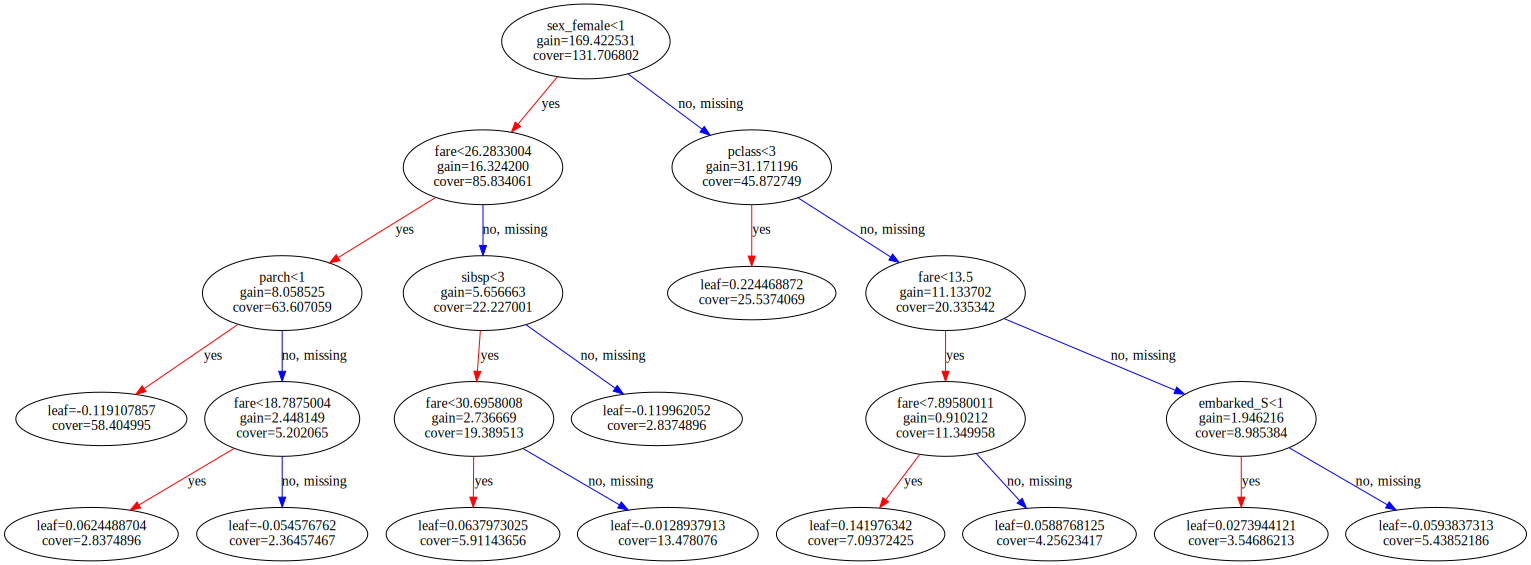

In [ ]:
booster = xgb_clf.get_booster()

# Dump trees as DOT with stats
dot_trees = booster.get_dump(dump_format="dot", with_stats=True)

tree_index = 0  # try different trees: 0, 1, 2, ...
dot_graph = dot_trees[tree_index]

# Render (requires Graphviz installed)
Source(dot_graph)

In [ ]:
# Fallback: write to file, then manually view if inline render doesn't work
with open("xgb_titanic_tree_0.dot", "w") as f:
    f.write(dot_graph)
print("Saved DOT to xgb_titanic_tree_0.dot")

Saved DOT to xgb_titanic_tree_0.dot


## Explainer Dashboard (SHAP-based)
Interactive dashboard to explore:
- **Global** feature importance and SHAP summary
- **Local** explanations for individual passengers
- Dependence plots & more

> This launches a local server. In Jupyter, set `open_browser=False` and click the output link.

In [ ]:
from explainerdashboard import ClassifierExplainer

# Pass DataFrame X_test so column names are carried through automatically.
explainer = ClassifierExplainer(
    xgb_clf,
    X_test,   # pandas DataFrame with named columns
    y_test    # pandas Series or 1D array
)

# (Optional quick sanity check)
print("Explainer columns:", list(explainer.columns)[:10], "…")
explainer

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Explainer columns: ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'] …


In [ ]:
from explainerdashboard import ExplainerDashboard

db = ExplainerDashboard(
    explainer,
    title="XGBoost — Titanic Survival Explainer",
    whatif=False,
    shap_interaction=False
)
# Choose a free port on your machine:
db.run(port=8052, open_browser=False)

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...


/usr/local/lib/python3.12/dist-packages/dash/dash.py:579: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://172.28.0.12:8052
You can terminate the dashboard with ExplainerDashboard.terminate(8052)


<IPython.core.display.Javascript object>

Dash app running on:
Try `serve_kernel_port_as_iframe` instead. 


<IPython.core.display.Javascript object>

/tmp/ipython-input-1520062742.py:8: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



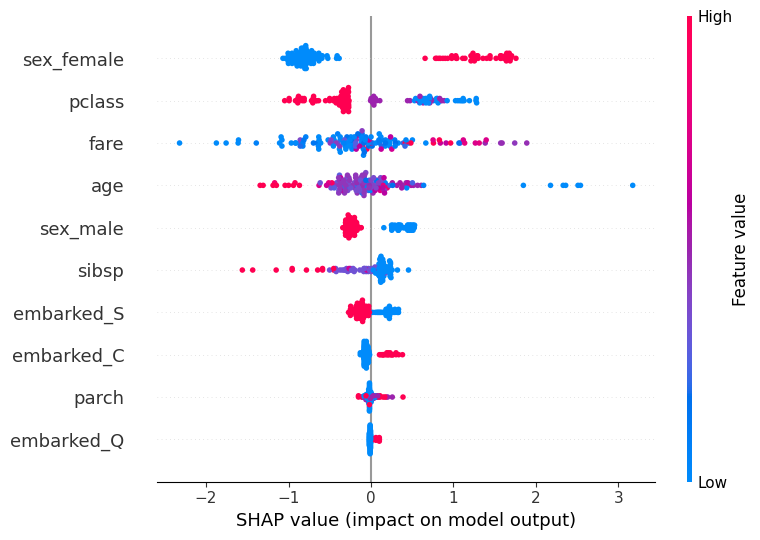

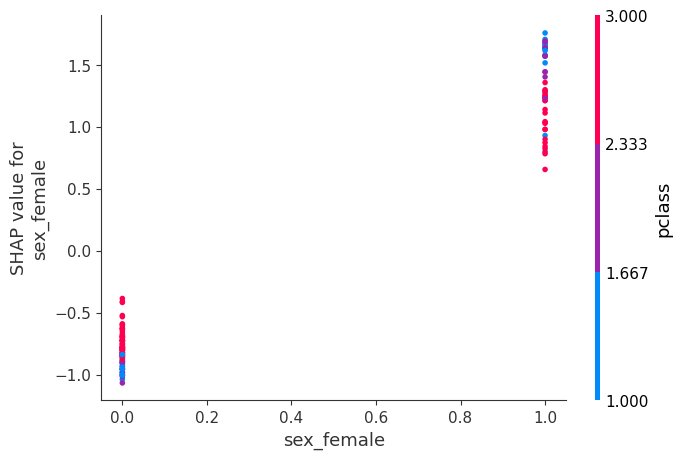

In [ ]:
import shap
shap.initjs()

explainer_shap = shap.TreeExplainer(xgb_clf)
shap_values = explainer_shap.shap_values(X_test)

# Global summary
shap.summary_plot(shap_values, X_test)

# Dependence plot for a top feature (change the feature name as needed)
shap.dependence_plot("sex_female", shap_values, X_test)

## Boosting vs Random Forest — Quick Head-to-Head
In this section we’ll compare **common gradient boosting models** with a **Random Forest** on a tabular task (Titanic; falls back to Breast Cancer if Titanic isn’t available).  
**What you’ll see:** simple preprocessing (impute + one-hot), fit each model with defaults, print **Accuracy**, and show a **clear bar chart**

In [ ]:
import sys, importlib.util, subprocess

def ensure(pkg, import_name=None, extra_args=()):
    """Install `pkg` via pip if `import_name` (or pkg) is not importable."""
    name = import_name or pkg
    if importlib.util.find_spec(name) is None:
        print(f"Installing {pkg} …")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg, *extra_args])
            print(f"Installed {pkg}.")
        except Exception as e:
            print(f"⚠️ Could not install {pkg}: {e}")
    else:
        print(f"{pkg} already available.")

# AdaBoost is part of scikit-learn; no install needed
ensure("lightgbm", "lightgbm")
ensure("catboost", "catboost")

# Show sklearn version for reference
try:
    import sklearn
    print("scikit-learn version:", sklearn.__version__)
except Exception as e:
    print("⚠️ scikit-learn not available:", e)

lightgbm already available.
Installing catboost …
Installed catboost.
scikit-learn version: 1.6.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Try seaborn Titanic, then OpenML Titanic, else Breast Cancer
X_raw = y = None
try:
    import seaborn as sns
    df = sns.load_dataset("titanic").rename(columns=str.lower)
    keep = [c for c in ["pclass","sex","age","sibsp","parch","fare","embarked","survived"] if c in df.columns]
    df = df[keep].dropna(subset=["survived"]).copy()
    df["survived"] = df["survived"].astype(int)
    X_raw = df.drop(columns=["survived"])
    y = df["survived"].astype(int)
except Exception:
    try:
        from sklearn.datasets import fetch_openml
        oml = fetch_openml(name="titanic", version=1, as_frame=True)
        df = oml.frame
        def to_int01(s):
            try:
                return s.astype(int)
            except Exception:
                return s.map({"yes":1,"no":0,"alive":1,"dead":0,"Yes":1,"No":0}).astype(int)
        y = to_int01(df["survived"])
        X_raw = df[["pclass","sex","age","sibsp","parch","fare","embarked"]].copy()
        X_raw["pclass"] = pd.to_numeric(X_raw["pclass"], errors="coerce")
    except Exception:
        from sklearn.datasets import load_breast_cancer
        bc = load_breast_cancer(as_frame=True)
        X_raw = bc.frame.drop(columns=["target"])
        y = bc.frame["target"]

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.25, stratify=y, random_state=42
)

# Column-wise preprocessing: median for numeric, most-freq+one-hot for categorical
num_cols = [c for c in X_train_raw.columns if X_train_raw[c].dtype != "object"]
cat_cols = [c for c in X_train_raw.columns if X_train_raw[c].dtype == "object"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    verbose_feature_names_out=False
)

X_train = preprocess.fit_transform(X_train_raw)
X_test  = preprocess.transform(X_test_raw)

[LightGBM] [Info] Number of positive: 256, number of negative: 412
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 203
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383234 -> initscore=-0.475846
[LightGBM] [Info] Start training from score -0.475846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



           Model  Accuracy  ROC_AUC
GradientBoosting  0.793722 0.807970
        CatBoost  0.789238 0.806527
        AdaBoost  0.784753 0.834790
        LightGBM  0.766816 0.790783
   HistGradBoost  0.762332 0.785817
    RandomForest  0.748879 0.814166


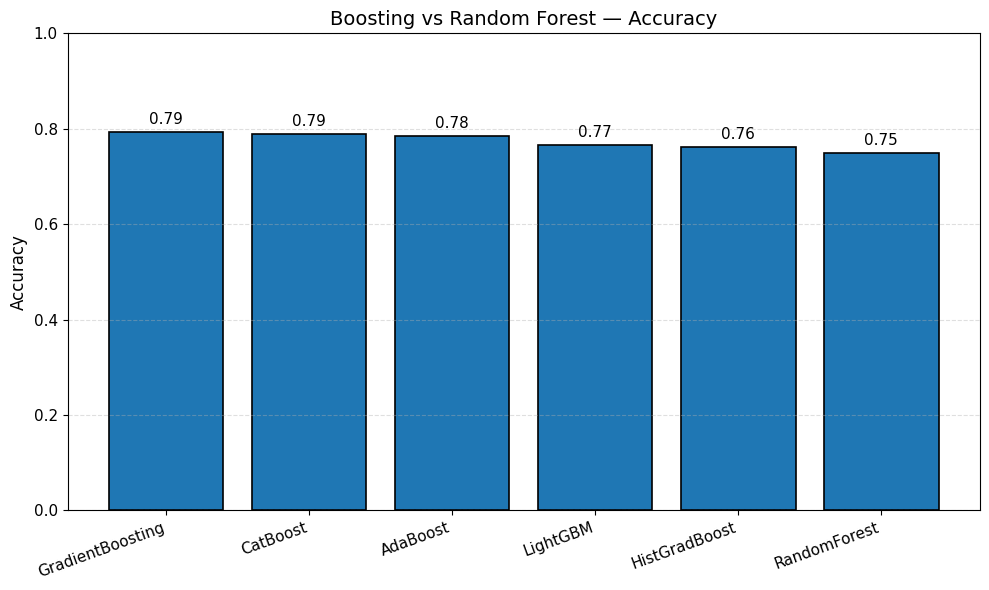

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=300, max_depth=None, max_features="sqrt",
        class_weight="balanced_subsample", random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42
    ),
    "HistGradBoost": HistGradientBoostingClassifier(
        max_depth=None, learning_rate=0.1, max_iter=300, random_state=42
    ),
    "AdaBoost": AdaBoostClassifier(
        n_estimators=300, learning_rate=0.5, random_state=42
    ),
}

# Optional: LightGBM (if installed)
try:
    from lightgbm import LGBMClassifier
    models["LightGBM"] = LGBMClassifier(
        n_estimators=300, learning_rate=0.1, num_leaves=31,
        subsample=0.9, colsample_bytree=0.9, random_state=42, n_jobs=-1
    )
except Exception:
    pass

# Optional: CatBoost (if installed)
try:
    from catboost import CatBoostClassifier
    models["CatBoost"] = CatBoostClassifier(
        iterations=300, learning_rate=0.1, depth=6,
        verbose=False, random_state=42
    )
except Exception:
    pass

# Train/evaluate
results = []
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    try:
        auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    except Exception:
        auc = np.nan
    results.append((name, acc, auc))

res_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC_AUC"]).sort_values("Accuracy", ascending=False)
print(res_df.to_string(index=False))

# --- Clearer bar chart (no custom colors; larger text, grid, labels) ---
plt.figure(figsize=(10, 6))
bars = plt.bar(res_df["Model"], res_df["Accuracy"], edgecolor="black", linewidth=1.2)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Boosting vs Random Forest — Accuracy", fontsize=14)
plt.xticks(rotation=20, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Add value labels on bars
for b, v in zip(bars, res_df["Accuracy"]):
    plt.text(b.get_x() + b.get_width()/2, v + 0.01, f"{v:.2f}",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.show()